In [0]:
import numpy as np
import pandas as pd

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
import time

In [0]:
### The experience replay memory ###
class ReplayBuffer:
  def __init__(self, obs_dim, act_dim, size):
    self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.acts_buf = np.zeros(size, dtype=np.uint8)
    self.rews_buf = np.zeros(size, dtype=np.float32)
    self.done_buf = np.zeros(size, dtype=np.uint8)
    self.ptr, self.size, self.max_size = 0, 0, size

  def store(self, obs, act, rew, next_obs, done):
    self.obs1_buf[self.ptr] = obs
    self.obs2_buf[self.ptr] = next_obs
    self.acts_buf[self.ptr] = act
    self.rews_buf[self.ptr] = rew
    self.done_buf[self.ptr] = done
    self.ptr = (self.ptr+1) % self.max_size
    self.size = min(self.size+1, self.max_size)

  def sample_batch(self, batch_size=32):
    idxs = np.random.randint(0, self.size, size=batch_size)
    return dict(s=self.obs1_buf[idxs],
                s2=self.obs2_buf[idxs],
                a=self.acts_buf[idxs],
                r=self.rews_buf[idxs],
                d=self.done_buf[idxs])

In [0]:
def cria_pasta(pasta):
  if not os.path.exists(pasta):
    os.makedirs(pasta)

In [0]:
def cria_modelo(n_parametros, n_acoes):

    rna = models.Sequential()
    rna.add(layers.Dense(32, activation='relu', input_shape=(n_parametros,)))
    rna.add(layers.Dense(16,activation='relu'))
    rna.add(layers.Dense(n_acoes, activation='softmax'))

    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)

    rna.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    rna.summary()

    return rna

In [0]:
class JogoDaVelhaEnv:
    def __init__(self):
        self.campo = None
        self.n_parametros = 9
        self.n_acoes = 9
        self.reseta(True)

    def reseta(self, comeca):
        self.campo = np.zeros(self.n_parametros)
        if not comeca:
            self.jogada_oponente()
        return self.observacao()
        
    def observacao(self):
        obs = np.empty(self.n_acoes)
        for i in range(self.n_acoes):
            obs[i] = self.campo[i]
        return obs
    
    def acabou(self):

        acabou = False
        valor = 0
        
        for i in range(3):
            if self.campo[0 + i] + self.campo[1 + i] + self.campo[2 + 1] in [3, -3]: #confere as linhas
                valor = self.campo[0 + i] + self.campo[1 + i] + self.campo[2 + 1]
            if self.campo[0 + i] + self.campo[3 + i] + self.campo[6 + i] in [3, -3]: #confere as colunas
                valor = self.campo[0 + i] + self.campo[3 + i] + self.campo[6 + i]
            
        if self.campo[0] + self.campo[4] + self.campo[8] in [3, -3]:
            valor = self.campo[0] + self.campo[4] + self.campo[8]
        if self.campo[2] + self.campo[4] + self.campo[6] in [3, -3]:
            valor = self.campo[2] + self.campo[4] + self.campo[6]

        valor = int(valor / 3)
        if valor != 0:
            acabou = True
        else:
            acabou = True
            for i in range(9):
                if self.campo[i] == 0:
                    acabou = False

        return [acabou, valor]

    def jogada_oponente(self):
        valido = False

        while not valido:
            jogada = np.random.choice(self.n_acoes)
            if self.campo[jogada] == 0:
                self.campo[jogada] = -1
                valido = True

    def step(self, acao):

        recompensa = None
        valido = None

        if self.campo[acao] == 0:
            self.campo[acao] = 1
            valido = True
            acabou = self.acabou()
            if acabou[0] and acabou[1] == 1:
                recompensa = 1
            elif acabou[0] and acabou[1] == 0:
                recompensa = -1
            else:
                recompensa = 0.2
        else:
            recompensa = -0.2
            valido = False

        if valido and not self.acabou()[0]:
            self.jogada_oponente()
            acabou = self.acabou()
            if acabou[0]:
                recompensa = -1

        # conform to the Gym API
        return self.observacao(), recompensa, self.acabou()[0], self.acabou()[1]

In [0]:
class DQNAgente(object):
    def __init__(self, n_parametros, n_acoes, n_episodios):
        self.n_parametros = n_parametros
        self.n_acoes = n_acoes
        self.memoria = ReplayBuffer(n_parametros, n_acoes, size=100)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = ( self.epsilon - self.epsilon_min ) / n_episodios
        self.modelo = cria_modelo(n_parametros, n_acoes)

    def acao(self, estado):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.n_acoes)
        vetor_acoes = self.modelo.predict( np.reshape( estado, (1, len(estado)) ) )
        return np.argmax(vetor_acoes)  # returns action
    
    def atualiza_memoria(self, estado, acao, recompensa, proximo_estado, terminou):
        self.memoria.store(estado, acao, recompensa, proximo_estado, terminou)

    def treina(self, batch_size=1):
        if self.memoria.size < batch_size: #confere se ja deve treinar
            return

        minibatch = self.memoria.sample_batch(batch_size) #pega a quantidade de linhas do batch_size para treinar
        estados = minibatch['s'] #pega os estados
        acoes = minibatch['a'] #pega as acoes
        recompensas = minibatch['r'] #pega as recompensas
        proximos_estados = minibatch['s2'] #pega os proximos estados
        terminous = minibatch['d'] #pega os terminous

        # Calculate the tentative target: Q(s',a)
        objetivo = recompensas + (1 - terminous) * self.gamma * np.amax(self.modelo.predict(proximos_estados), axis=1)

        objetivos = self.modelo.predict( np.reshape( estados, (len(estados), len(estados[0])) ) )
        objetivos[np.arange(batch_size), acoes] = objetivo

        # Run one training step
        self.modelo.train_on_batch(estados, objetivos)

    def decair_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

    def salva_pesos(self, caminho):
        self.modelo.save_weights(caminho)

    def carrega_pesos(self, caminho):
        self.modelo.load_weights(caminho)

In [0]:
def play_one_episode(agente, ambiente, treino, episodio):
    comeca = (episodio % 2 == 0)
    estado = ambiente.reseta(comeca)
    terminou = False
    ganhou = None
    soma_recompensa = 0

    while not terminou:
        acao = agente.acao(estado)
        proximo_estado, recompensa, terminou, ganhou = ambiente.step(acao)
        if treino:
            agente.atualiza_memoria(estado, acao, recompensa, proximo_estado, terminou)
            agente.treina(batch_size)
        estado = proximo_estado
        soma_recompensa += recompensa

    agente.decair_epsilon()
    return ganhou, soma_recompensa

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
Episodio: 100/1000, media recompensas: -76.20, media IA: 42.00%, media Aleatorio: 34.00%, media Deu velha: 24.00%, tempo: 0:00:45.233360
Episodio: 200/1000, media recompensas: -27.60, media IA: 49.00%, media Aleatorio: 39.00%, media Deu velha: 12.00%, tempo: 0:00:34.329349
Episodio: 300/1000, media recompensas: -32.00, media IA: 46.00%, media Aleatorio: 34.00%, media Deu velha: 20.

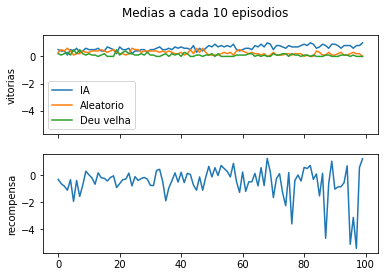

In [8]:
if __name__ == '__main__': #caso esse seja o codigo principal rodando, roda
    t_ini = datetime.now() #variavel para ver quanto tempo demora para rodar o codigo todo
    
    pasta_modelos = 'modelos_rl' #pasta para salvar os modelos
    pasta_recompensas = 'recompensas_rl' #pasta para salvar os resultados
    n_episodios = 1000 #numero de "epocas"
    divisor_val = 10 #variavel para definir a cada quantos episodios vai guardar os valores
    divisor_print = int(n_episodios / 10) #variavel para definir a cada quantos episodios vai mostrar os valores
    batch_size = 1 #treinar depois de batch_size jogadas tentadas

    args = {'modo':'treino'} #argumento para definir so modo que o algoritmo vai rodar (treino ou teste)

    cria_pasta(pasta_modelos) #cria a pasta de modelos caso ainda nao exista
    cria_pasta(pasta_recompensas) #cria a pasta de resultados caso ainda nao exista

    ambiente = JogoDaVelhaEnv() #cria o ambiente para o jogo
    n_parametros = ambiente.n_parametros #define o numero de entradas da rede
    n_acoes = ambiente.n_acoes #define o numero de saidas da rede
    agente = DQNAgente(n_parametros, n_acoes, n_episodios) #cria o agente que vai ser treinado

    ganhadores = [] #variavel para guardar quem ganhou em casa episodio
    recompensas = [] #variavel para guardar as recompensas de todos os episodios
    media_recompensas = [] #variavel para guardar a media das recompensas
    media_ia = [] #variavel para guardar as medias de vitoria da ia
    media_aleatorio = [] #variavel para guardar as medias de vitoria do oponente aleatorio
    media_velha = [] #variavel para guardar as medias de jogos que deram velha
    jogos = [] #variavel para guardar o resultado do jogo

    if args['modo'] == 'teste': #caso o algoritmo esteja em modo teste
        agente.carrega_pesos(f'{pasta_modelos}/dqn.h5') #carrega os pesos da rede
        agente.epsilon = 0 #define a aleatoriedade das acoes = 0%

    t_ini_ep = datetime.now() #variavel para ver quanto tempo demora para rodar os episodios
    for episodio in range(n_episodios): #roda para a quantidade de episodios especificada
        resultado, recompensa = play_one_episode(agente, ambiente, args['modo'] == 'treino', episodio) #roda um episodio

        ganhador = None #define uma variavel para quem ganhou o jogo
        if resultado == 1: #se o resultado for 1
            ganhador = 'IA' #o ganhador foi a IA
        elif resultado == -1: #se o resultado for -1
            ganhador = 'Aleatorio' #o ganhador foi o oponente aleatorio
        else: #se o resultado for 0
            ganhador = 'Deu velha' #o jogo deu velha

        ganhadores.append(resultado) #adiciona quem ganhou na lista de ganhadores
        recompensas.append(recompensa) #adiciona a recompensa final do episodio na lista de recompensas
        jogos.append(ambiente.campo) #adiciona o resultado do jogo na variavel de jogos
        
        if (episodio + 1) % divisor_val == 0: #se a quantidade de episodios for divisivel pelo divisor de valores, guarda os dados
            media_recompensas.append( sum(recompensas[-divisor_val:]) / divisor_val ) #adiciona a media das recompensas dos ultimos (divisor_val) episodios
            media_ia.append( ganhadores[-divisor_val:].count(1) / divisor_val ) #adiciiona a media de vitorias da IA dos ultimos (divisor_val) episodios
            media_aleatorio.append( ganhadores[-divisor_val:].count(-1) / divisor_val ) #adiciiona a media de vitorias do oponente aleatorio dos ultimos (divisor_val) episodios
            media_velha.append( ganhadores[-divisor_val:].count(0) / divisor_val ) #adiciiona a media de jogos que deram velha dos ultimos (divisor_val) episodios

        if (episodio + 1) % divisor_print == 0: #se a quantidade de episodios for divisivel pelo divisor de prints, printa os dados
            if len(media_ia) > 0: #se ja tiverem valores
                m_r = ( sum(recompensas[-divisor_print:]) / divisor_print ) * 100 #calcula a media de recompensas dos ultimos (divisor_print) episodios
                m_ia = ( ganhadores[-divisor_print:].count(1) / divisor_print ) * 100 #calcula a media de vitorias da IA dos ultimos (divisor_print) episodios
                m_ale = ( ganhadores[-divisor_print:].count(-1) / divisor_print ) * 100 #calcula a media de vitorias do oponente aleatorio dos ultimos (divisor_print) episodios
                m_velha = ( ganhadores[-divisor_print:].count(0) / divisor_print ) * 100 #calcula a media de jogos que deram velha (divisor_print) episodios
                t_fim_ep = datetime.now() - t_ini_ep #define quanto tempo demorou os episodios
                print(f"Episodio: {episodio + 1}/{n_episodios}, media recompensas: {m_r:.2f}, media IA: {m_ia:.2f}%, media Aleatorio: {m_ale:.2f}%, media Deu velha: {m_velha:.2f}%, tempo: {t_fim_ep}") #printa as informacoes
                t_ini_ep = datetime.now() #reseta a variavel de tempo dos episodios

    if args['modo'] == 'treino': #caso o algoritmo esteja em modo treino
        agente.salva_pesos(f'{pasta_modelos}/dqn.h5') #salva os pesos da rede

    np.save(f'{pasta_recompensas}/{args["modo"]}.npy', [ganhadores, jogos]) #salva os resultados de todos os episodios

    t_fim = datetime.now() - t_ini #define quanto tempo demorou o algoritmo todo
    print(args['modo'] + 'finalizado em ' + str(t_fim)) #mostra quanto tempo demorou

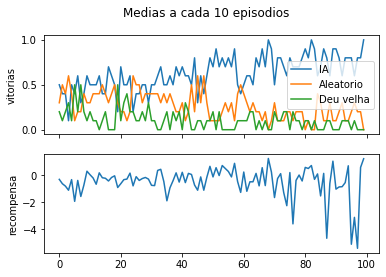

In [9]:
x_plot = np.arange(len(media_recompensas)) #define variavel para plotar em x no primeiro grafico

fig, axs = plt.subplots(2, sharex=True)
fig.suptitle(f'Medias a cada {divisor_val} episodios')
axs[0].set(ylabel='vitorias')
axs[0].plot(x_plot, media_ia, label='IA')
axs[0].plot(x_plot, media_aleatorio, label='Aleatorio')
axs[0].plot(x_plot, media_velha, label='Deu velha')
axs[0].legend() #adiciona uma legenda
axs[1].set(ylabel='recompensa')
axs[1].plot(x_plot, media_recompensas)

fig.savefig('result.png', bbox_inches='tight') #salva o grafico em uma foto